## Instruction
In this notebook, we load data from privious step in `Factor_Process_and_Evaluate.ipynb` and we combine all factors by RandomForest method. Then we can evaluate all factors.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import helper.project_helper as ph

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
## load universe_factors
universe = pd.read_csv('factor_data/all_108_zscore.csv')
universe['date'] = pd.to_datetime(universe['trade_date'],format='%Y%m%d')
universe.set_index(['date'],inplace=True)
universe = universe.loc[universe['trade_date']>20190401]
universe = universe.fillna(0.)
universe.tail()

,ts_code,trade_date,turnover_rate,pe,pb,ps,dv_ratio,total_share,free_share,total_mv,...,alpha_122,alpha_069,alpha_056,alpha_030,alpha_083,rsize,rvalue,section1,section2,ind_val
date,,,,,,,,,,,,,,,,,,,,,
2023-04-26,300463.SZ,20230426,1.2489,13.9545,1.5432,2.7378,2.9014,61246.9590,42289.3838,9.879134e+05,...,0.388148,0.447885,1.0,0.929893,0.246910,0.851852,0.111111,0.008092,-0.011628,1.0
2023-04-26,300378.SZ,20230426,3.8989,47.9125,2.9342,3.0061,0.4919,26703.4230,20758.4473,5.375399e+05,...,-0.124647,-0.169887,1.0,0.762360,-0.492860,0.638889,0.509259,-0.038016,-0.011628,0.0
2023-04-26,300363.SZ,20230426,1.5592,9.3840,2.9706,2.6751,0.5581,54595.5020,32003.8418,1.881907e+06,...,0.427880,0.305331,1.0,0.090811,0.345514,0.990741,0.518519,0.016674,-0.011628,1.0
2023-04-26,300556.SZ,20230426,12.2727,58.4739,3.1597,2.0891,0.3543,12122.7704,10048.9702,2.697316e+05,...,-0.084319,-0.077573,1.0,0.635836,0.283887,0.148148,0.555556,-0.093470,-0.011628,0.0
2023-04-26,688799.SH,20230426,2.5032,23.6249,2.3823,3.3124,0.0000,9380.0000,4211.3000,3.797962e+05,...,-0.115994,0.275642,-1.0,-0.217684,0.211166,0.416667,0.351852,0.041862,-0.011628,1.0


### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [3]:
all_factors = universe.copy(deep=True)
universe.industry.unique()

array(['医药商业', '软件服务', '化学制药', 'IT设备', '互联网', '中成药', '生物制药', '化工原料',
       '医疗保健', '元器件', '半导体'], dtype=object)

In [4]:
# sector_dict = {'软件服务':1, '医疗保健':2, '化学制药':3, '中成药':4, 'IT设备':5, '互联网':6, '生物制药':7, '化工原料':8,
#        '医药商业':9, '元器件':10, '半导体':11}
sector_dict = {1:1, 0:0}
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['ind_val']==sector_name, True, False)

all_factors.head()

,ts_code,trade_date,turnover_rate,pe,pb,ps,dv_ratio,total_share,free_share,total_mv,...,alpha_056,alpha_030,alpha_083,rsize,rvalue,section1,section2,ind_val,sector_1,sector_0
date,,,,,,,,,,,,,,,,,,,,,
2019-04-02,000411.SZ,20190402,3.3493,35.8792,3.2739,0.1584,0.0000,20744.9946,9393.7349,299557.7220,...,0.0,-0.448979,-0.339333,0.0,0.0,0.0,0.0,0.0,False,True
2019-04-02,002322.SZ,20190402,2.9820,22.8375,2.1683,7.5718,3.0138,39666.2205,20665.0203,637436.1634,...,0.0,-0.763394,-0.131544,0.0,0.0,0.0,0.0,0.0,False,True
2019-04-02,002362.SZ,20190402,4.3341,249.8015,4.6423,5.3032,0.0000,21703.1292,13245.2747,396299.1392,...,0.0,0.691542,0.100046,0.0,0.0,0.0,0.0,0.0,False,True
2019-04-02,002365.SZ,20190402,7.3539,20.8243,2.3539,3.6989,0.5283,29468.2500,21577.9177,371889.3150,...,0.0,-0.602188,0.689225,0.0,0.0,0.0,0.0,0.0,False,True
2019-04-02,002380.SZ,20190402,3.4423,32.5786,1.7668,6.0030,0.9849,23999.1649,11072.7327,365507.2814,...,0.0,0.372448,-0.483631,0.0,0.0,0.0,0.0,0.0,False,True


### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [5]:
quantile_jud = all_factors['log-ret'].quantile([0.3,0.7,1.])
quantile_jud

0.3   -0.012579
0.7    0.011023
1.0    0.258654
Name: log-ret, dtype: float64

In [6]:
def get_return_quantiles(all_factors):
    all_factors['return_2q'] = 0
    all_factors['return_2q'] = np.where(all_factors['log-ret']<=-0.01, -1, all_factors['return_2q'])
    all_factors['return_2q'] = np.where(all_factors['log-ret']>=0.01, 1 , all_factors['return_2q'])
        
    return all_factors

all_factors = get_return_quantiles(all_factors)

### Shift Target
We'll use shifted 5 day returns for training the model.

As some alpha factors measure time is not same, we can also shift.

In [7]:
# save all_factors which is no need to train
universe = all_factors.copy(deep=True)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-2).fillna(0).astype(np.int16)

In [8]:
all_factors['target'].unique()
#all_factors.loc[all_factors['target']==0].trade_date.unique()

array([ 0,  1, -1], dtype=int16)

### IID Check of Target
Let's see if the returns are independent and identically distributed.

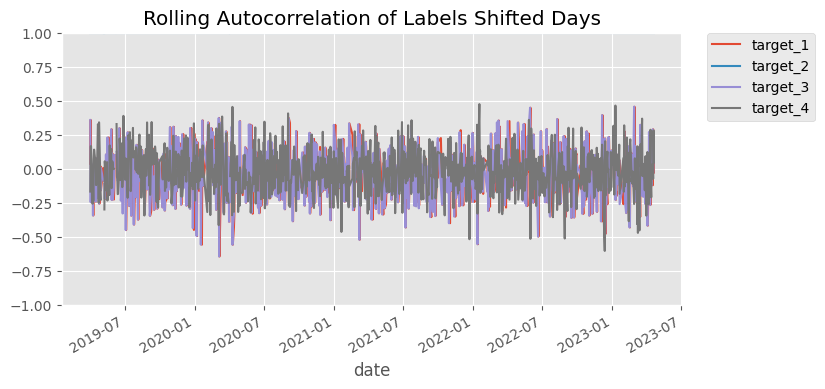

In [13]:
all_factors.reset_index(inplace=True)
all_factors.set_index(['date','ts_code'],inplace=True)
tmp = all_factors.loc[all_factors['trade_date']>20220701].sort_index(level=['date', 'ts_code'])
ph.IID_check(all_factors)

### Train/Valid/Test Splits
Split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [14]:
features = [
            'alpha_kama', 'alpha_atr14', 'alpha_atr', 'alpha_fundamental', 'alpha_ppo',
            'alpha_009', 'alpha_010','alpha_pb',  'alpha_101',  'alpha_103',
            'alpha_149', 'alpha_075', 'alpha_122', 'alpha_069', 'alpha_056', 'alpha_030', 'alpha_083', 
            ] + sector_columns

target_label = 'target'
print(all_factors.shape)

(86917, 73)


In [15]:
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
all_factors.reset_index(inplace=True)
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date','ts_code']).sort_index(level=['date'])
print(all_factors.shape)
all_factors.head()

(86485, 73)


trade_date  turnover_rate        pe      pb      ps  \
date       ts_code                                                          
2019-04-02 000411.SZ    20190402         3.3493   35.8792  3.2739  0.1584   
           000756.SZ    20190402         2.1743   19.5855  1.8281  0.9433   
           000915.SZ    20190402         3.6041   44.4305  3.6061  3.7755   
           002322.SZ    20190402         2.9820   22.8375  2.1683  7.5718   
           002362.SZ    20190402         4.3341  249.8015  4.6423  5.3032   

                      dv_ratio  total_share  free_share     total_mv  \
date       ts_code                                                     
2019-04-02 000411.SZ    0.0000   20744.9946   9393.7349  299557.7220   
           000756.SZ    0.7790   62185.9447  19463.0985  491268.9631   
           000915.SZ    1.0167   23433.1485  18488.8117  576221.1216   
           002322.SZ    3.0138   39666.2205  20665.0203  637436.1634   
           002362.SZ    0.0000   21703.1292  13245.2747  396299.1392   

                          circ_mv  ... section2 ind_val  sector_1  sector_0  \
date       ts_code                 ...                                        
2019-04-02 000411.SZ  299343.1075  ...      0.0     0.0     False      True   
           000756.SZ  315601.1108  ...      0.0     0.0     False      True   
           000915.SZ  574010.4118  ...      0.0     0.0     False      True   
           002322.SZ  579857.9753  ...      0.0     0.0     False      True   
           002362.SZ  324841.3846  ...      0.0     0.0     False      True   

                      return_2q  target  target_1  target_2  target_3  \
date       ts_code                                                      
2019-04-02 000411.SZ          1       0      -1.0       0.0       0.0   
           000756.SZ         -1       0       1.0       0.0       1.0   
           000915.SZ          0      -1       0.0      -1.0      -1.0   
           002322.SZ          1       1       1.0       1.0       1.0   
           002362.SZ          0       0       0.0       0.0      -1.0   

                      target_4  
date       ts_code              
2019-04-02 000411.SZ       1.0  
           000756.SZ      -1.0  
           000915.SZ       1.0  
           002322.SZ       1.0  
           002362.SZ       1.0  

[5 rows x 73 columns]

In [22]:
tmp = all_factors.dropna().copy()
X = tmp[features]
y = tmp[target_label].astype(np.int16)

X_train, X_valid, X_test, y_train, y_valid, y_test = ph.train_valid_test_split(X, y, 0.75, 0.2, 0.05)

X_valid.tail()

alpha_kama  alpha_atr14  alpha_atr  alpha_fundamental  \
date       ts_code                                                            
2023-02-08 688358.SH    0.317697    -0.383847  -0.411888          -0.785081   
           688579.SH    0.736456     0.510145   0.541783          -0.221957   
           688589.SH   -0.080579    -0.258015  -0.245022          -0.712573   
           688655.SH    0.397299     0.711196   0.682947          -0.016105   
           688799.SH   -0.016231    -0.158910   0.071266          -0.239808   

                      alpha_ppo  alpha_009  alpha_010  alpha_pb  alpha_101  \
date       ts_code                                                           
2023-02-08 688358.SH   0.146303  -0.431434  -0.359524 -0.177248       -1.0   
           688579.SH  -0.021065   0.835686   0.906281 -0.205169       -1.0   
           688589.SH   0.080330  -0.327821  -0.334856 -0.471511       -1.0   
           688655.SH  -0.038039   0.823774   0.831278  0.138462       -1.0   
           688799.SH   0.290203  -0.082546  -0.295360  0.416598       -1.0   

                      alpha_103  alpha_149  alpha_075  alpha_122  alpha_069  \
date       ts_code                                                            
2023-02-08 688358.SH  -1.000000   0.081644  -0.449034   0.112876   0.763941   
           688579.SH   0.461959  -0.317960   0.234814  -0.139425   0.526455   
           688589.SH  -1.000000  -0.418052  -0.104681   0.010374   0.212995   
           688655.SH  -1.000000   0.493666  -0.173551  -0.165227  -0.391193   
           688799.SH  -0.408220   0.165540  -0.173551   0.224038   0.101472   

                      alpha_056  alpha_030  alpha_083  sector_1  sector_0  
date       ts_code                                                         
2023-02-08 688358.SH       -1.0  -0.016902  -0.545323     False      True  
           688579.SH       -1.0  -0.018241   0.156620     False      True  
           688589.SH       -1.0   0.671919   0.089934     False      True  
           688655.SH        1.0   0.965355   0.274301     False      True  
           688799.SH       -1.0   0.512641   0.258610     False      True

In [23]:
X_test.head()

alpha_kama  alpha_atr14  alpha_atr  alpha_fundamental  \
date       ts_code                                                            
2023-02-09 000411.SZ    0.765028     0.646725   0.767705               -1.0   
           000756.SZ   -0.048089    -0.237124   0.182983               -1.0   
           000915.SZ    0.117892    -0.384434  -0.320742               -1.0   
           002322.SZ    0.331873     0.847518   0.772016               -1.0   
           002362.SZ   -1.000000    -0.386081  -0.551276               -1.0   

                      alpha_ppo  alpha_009  alpha_010  alpha_pb  alpha_101  \
date       ts_code                                                           
2023-02-09 000411.SZ   0.436285   0.920568   0.880169  0.516960  -1.000000   
           000756.SZ   1.000000   0.433969  -0.067999 -0.407709  -1.000000   
           000915.SZ   0.541021  -0.341303  -0.382335 -0.268315  -1.000000   
           002322.SZ  -0.182361   0.929491   0.930597  0.832576   0.869869   
           002362.SZ  -1.000000  -0.130770  -0.299557 -0.702732  -1.000000   

                      alpha_103  alpha_149  alpha_075  alpha_122  alpha_069  \
date       ts_code                                                            
2023-02-09 000411.SZ  -1.000000  -0.229086  -0.071698   0.397433  -0.011490   
           000756.SZ   0.963723  -0.369015  -0.381132   1.000000   1.000000   
           000915.SZ   0.276248   0.087267   0.238025   0.424572   0.155941   
           002322.SZ  -1.000000   0.157870   0.238025  -0.370872  -0.281689   
           002362.SZ  -0.793813  -0.436788  -0.613208  -1.000000  -1.000000   

                      alpha_056  alpha_030  alpha_083  sector_1  sector_0  
date       ts_code                                                         
2023-02-09 000411.SZ        1.0   0.632384  -0.124515     False      True  
           000756.SZ        1.0   0.336077  -0.121672     False      True  
           000915.SZ       -1.0  -0.363161   0.265136     False      True  
           002322.SZ       -1.0   0.822264   0.323458     False      True  
           002362.SZ       -1.0  -1.000000  -0.588913     False      True

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [48]:
n_days = 60
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 200,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [10, 20, 30]

### Pick Important Features by Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|█████████████████████████| 3/3 [00:03<00:00,  1.14s/Model]


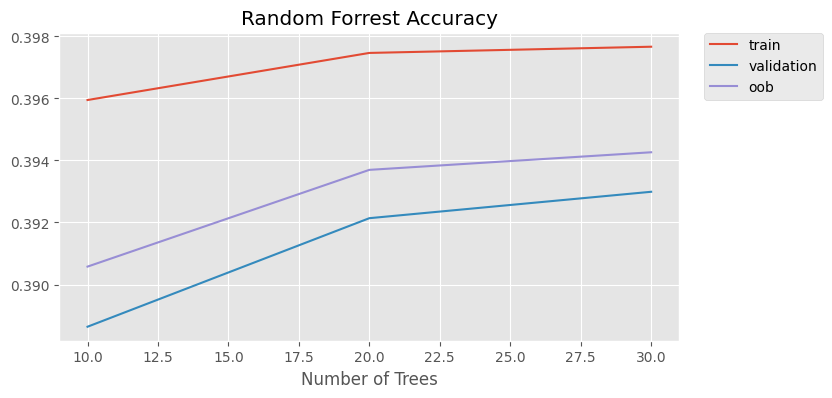

Features Ranked by Average Importance:

      Feature               Importance
 1. alpha_atr         (0.25789002895468416)
 2. alpha_pb          (0.1845541592814933)
 3. alpha_atr14       (0.1730965951086263)
 4. alpha_075         (0.09180181701861591)
 5. alpha_103         (0.06990117171132008)
 6. alpha_122         (0.05970600143904722)
 7. alpha_ppo         (0.057659794759117776)
 8. alpha_149         (0.03118251694870702)
 9. alpha_010         (0.02056614293915835)
10. alpha_056         (0.015045491643746536)
11. alpha_030         (0.013700489371217867)
12. alpha_009         (0.012554021892723415)
13. alpha_083         (0.004392817337525398)
14. alpha_fundamental (0.003157989054817208)
15. alpha_kama        (0.0029655798512990606)
16. alpha_069         (0.001825382687900443)
17. alpha_101         (0.0)
18. sector_1          (0.0)
19. sector_0          (0.0)


In [50]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')
print('Features Ranked by Average Importance:\n')
ph.rank_features_by_importance(np.average(feature_importances, axis=0), features)

### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

class NoOverlapVoter(VotingClassifier):
    
    def _calculate_oob_score(self, classifiers):
        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_
        return oob / len(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        estimators_ = []
        for i in range(n_skip_samples):
            estimators_.append(
                classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            )
        return estimators_
    
    def __init__(self, estimator, voting='soft', n_skip_samples=3):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

### Train Model

In [60]:
n_days = 30
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    #'criterion': 'entropy',
    #'min_samples_split' : 100,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [10, 20, 30]

train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|█████████████████████████| 3/3 [00:04<00:00,  1.65s/Model]


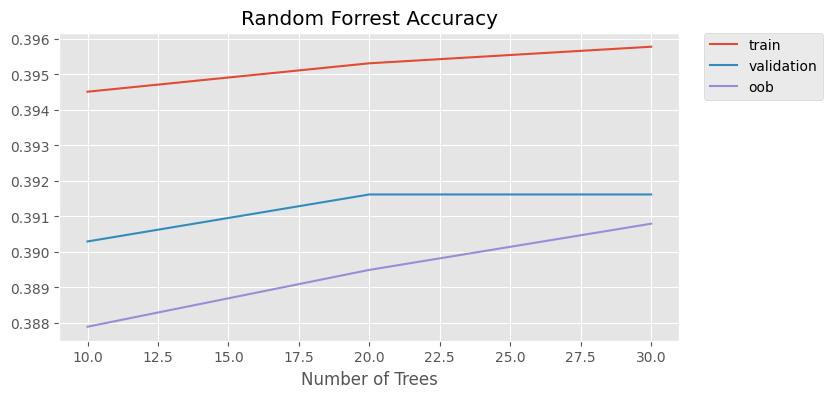

In [61]:
ph.plot(
    [n_trees_l]*5,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
predictions = clf_nov.predict(X_valid)

# Score our model average='micro' if report error
print('Accuracy score: ', format(accuracy_score(y_valid.values, predictions)))
print('Precision score: ', format(precision_score(y_valid.values, predictions, average='micro')))
print('Recall score: ', format(recall_score(y_valid.values, predictions, average='micro')))
print('F1 score: ', format(f1_score(y_valid.values, predictions, average='micro')))

Accuracy score:  0.3916189755474625
Precision score:  0.3916189755474625
Recall score:  0.3916189755474625
F1 score:  0.3916189755474625


In [64]:
factor_names = [ 
            'alpha_kama', 'alpha_atr14', 'alpha_atr', 'alpha_fundamental', 'alpha_009', 'alpha_ppo', 
            'alpha_pb', 'alpha_149', 'alpha_030', 'alpha_083',
            #'alpha_010',  'alpha_101',  'alpha_103',
            #'alpha_075', 'alpha_122', 'alpha_069', 'alpha_056',   
            ]

all_pricing = all_factors.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-2)
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')

### Evalueate alpha factor

In [66]:
import alphalens as al
from scipy.stats import zscore

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    factors_with_alpha = factors_with_alpha.reset_index()
    factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
    factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    # only for long factor evaluate
    #for name in (factors + [alpha_score_label]):
    #    factors_with_alpha[name] = np.where(factors_with_alpha[name]>0, factors_with_alpha[name], 0.)
        
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing, holding_time=3)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.0% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

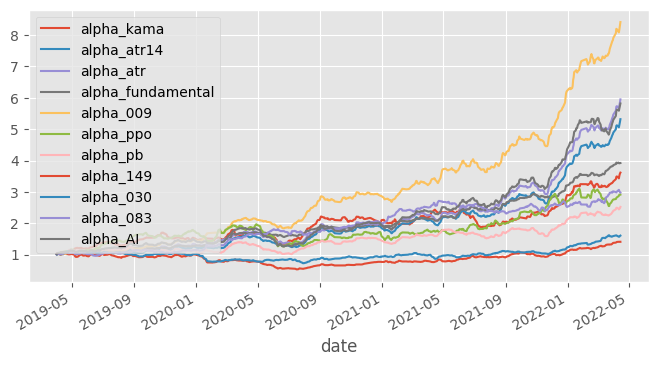

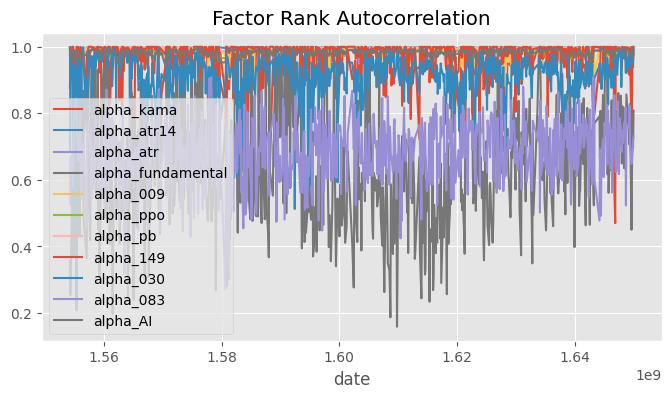

In [67]:
show_sample_results(all_factors, X_train, clf_nov, factor_names, pricing=all_pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

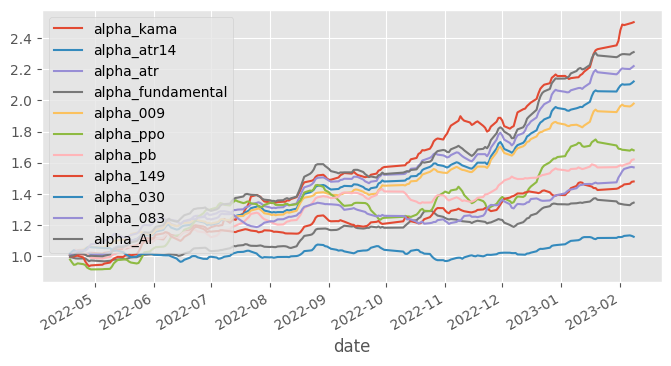

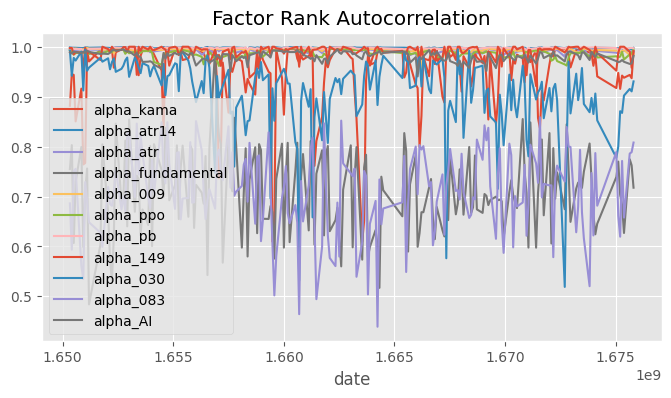

In [68]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing=all_pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [69]:
n_days = 30
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 100,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees = 25

train_score = []
valid_score = []
oob_score = []

clf = RandomForestClassifier(n_trees, **clf_parameters)
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

train_score.append(clf_nov.score(X_train, y_train.values))
valid_score.append(clf_nov.score(X_valid, y_valid.values))
oob_score.append(clf_nov.oob_score_)

In [70]:
print(train_score)
print(valid_score, oob_score)

[0.396683460678656]
[0.39488246701035806] [0.39300733460003867]


### View Train Set Results

Cleaning Data...

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

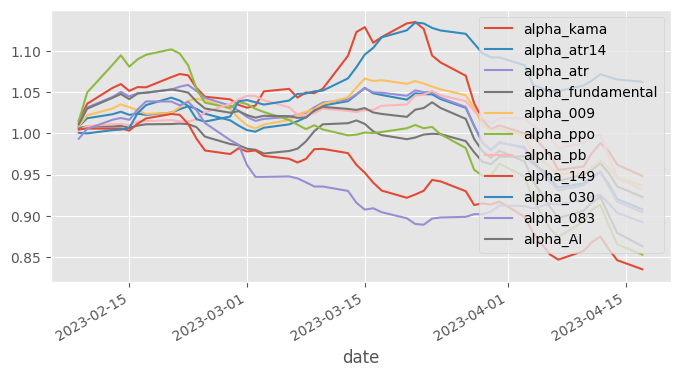

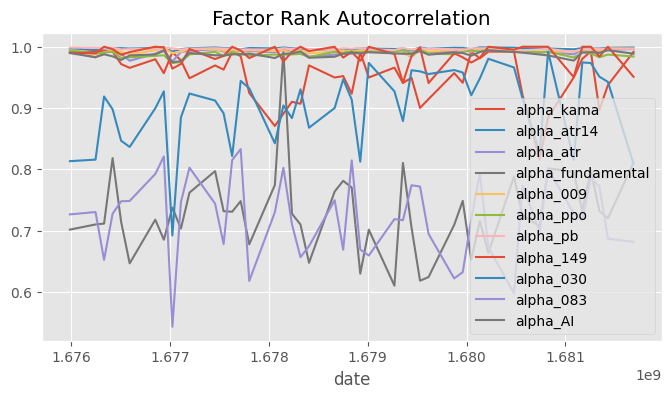

In [71]:
#show_sample_results(all_factors, pd.concat([X_train, X_valid]), clf_nov, factor_names, pricing=all_pricing)
show_sample_results(all_factors, X_test, clf_nov, factor_names, pricing=all_pricing)

### View Test Set Results

Cleaning Data...

Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

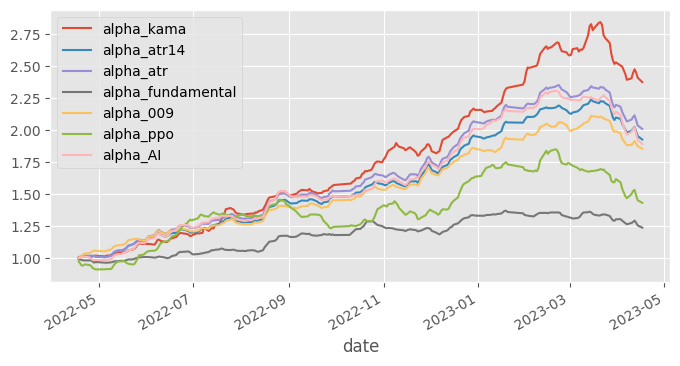

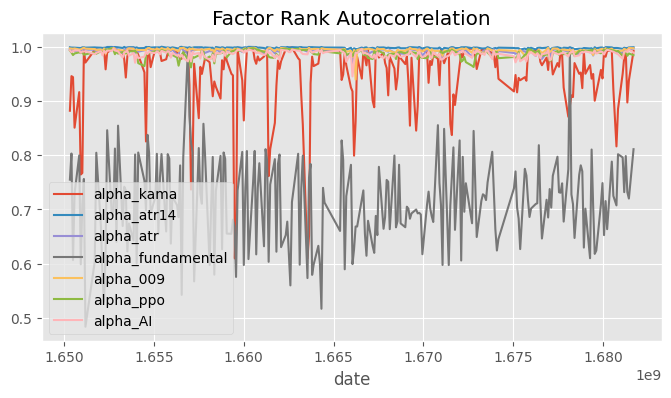

In [72]:
factor_names = [
            'alpha_kama', 'alpha_atr14', 'alpha_atr', 'alpha_fundamental', 'alpha_009', 'alpha_ppo', 
            #'alpha_pb', 'alpha_149', 'alpha_030', 'alpha_083',
            #'alpha_010',  'alpha_101',  'alpha_103',
            #'alpha_075', 'alpha_122', 'alpha_069', 'alpha_056',   
           ]
#tmp = pd.concat([X_train, X_valid])
tmp = pd.concat([X_valid, X_test])
show_sample_results(all_factors, tmp, clf_nov, factor_names, pricing=all_pricing)

### Merage AI factors

In [73]:
def save_AI_factors(data, classifier):
    # Calculate the Alpha Score
    samples = data[features]
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))

    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    print(alpha_score, len(alpha_score))
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
#     factors_with_alpha = factors_with_alpha.reset_index()
#     factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
#     factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    return factors_with_alpha

sample_all = universe.reset_index()
sample_all.set_index(['date','ts_code']).sort_values(by=['date'])
save_factors = save_AI_factors(sample_all, clf_nov)
save_factors = save_factors.reset_index().set_index(['date'])
save_factors = universe.merge(save_factors[['alpha_AI','ts_code','trade_date']], on=['ts_code','trade_date'], how='left')

[-0.00297612 -0.03736925 -0.03418655 ... -0.00712621 -0.02223624
 -0.01879335] 86917


<AxesSubplot:>

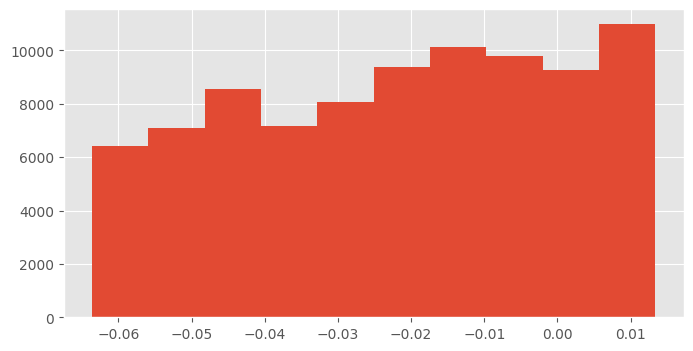

In [74]:
save_factors['alpha_AI'].hist()

In [75]:
#save_factors['alpha_pb'] = -save_factors['pb']
field = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
         'alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI', 
        ]
save_factors[field].to_csv('AI_data/factors_AI_108.csv')

In [77]:
save_factors[field]

,ts_code,trade_date,name,industry,close,log-ret,alpha_atr,alpha_kama,alpha_009,alpha_AI
0,000411.SZ,20190402,英特集团,医药商业,11.62218,0.034522,0.612679,1.000000,0.000000,-0.002976
1,002322.SZ,20190402,理工能科,软件服务,13.86588,0.064248,-0.062767,-0.125348,0.000000,-0.037369
2,002362.SZ,20190402,汉王科技,软件服务,18.26000,0.008801,-0.198308,-0.061443,0.000000,-0.034187
3,002365.SZ,20190402,永安药业,化学制药,12.18768,0.051210,0.213140,0.039356,0.000000,-0.004250
4,002380.SZ,20190402,科远智慧,软件服务,14.43875,0.012553,0.195505,-0.051100,0.000000,-0.025084
...,...,...,...,...,...,...,...,...,...,...
86912,300463.SZ,20230426,迈克生物,医疗保健,16.13000,0.008092,0.787555,0.048427,-0.904444,0.011623
86913,300378.SZ,20230426,鼎捷软件,软件服务,20.13000,-0.038016,0.236590,-0.710834,-0.669316,-0.016758
86914,300363.SZ,20230426,博腾股份,化学制药,34.47000,0.016674,0.168845,0.044349,-0.371416,-0.007126
86915,300556.SZ,20230426,丝路视觉,软件服务,22.25000,-0.093470,-0.040039,0.046305,-0.504858,-0.022236


### Save RandomForest Model

In [76]:
import joblib

joblib.dump(clf_nov, 'AI_data/clf_108.pkl')


['AI_data/clf_108.pkl']

Load model example

In [ ]:
clf_load = joblib.load('clf_20230401.pkl') 
alpha_score = clf_load.predict_proba(all_factors[features]).dot(np.array([-1, 0, 1]))
print(alpha_score, len(alpha_score))